In [ ]:
#!pip install nltk tensorflow

In [ ]:
import pandas as pd
import numpy as np

import gensim
import nltk
nltk.download('punkt')
import tensorflow as tf

import seaborn as sns
import matplotlib.pyplot as plt

import ast

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import log_loss

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from matplotlib.ticker import MultipleLocator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## In this notebook, I will create two different Bi-Directional LSTM models to predict genre of songs. The performance of this model, as well as it's contribution to the ensemble model, will be compared against the Logistic Regression and HAN models.

### 1) Loading in Trained Word2Vec Model and Creating Embeddings

More details for my specific creation of the csutom word2vec model and document/line embeddings can be found in the baselineLogisticRegression - Lyric Content notebook.

In [ ]:
model_path = "/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/word_two_vec_model.model"
model_w2v = Word2Vec.load(model_path)

#### a. Process training data by splitting into train/validation split ('testing' blind data is from another file) and tokenizing

In [ ]:
lstm_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/train_clean_w_sentiment.csv')

In [ ]:
lyric_lists = [song.splitlines() for song in lstm_data['Lyrics']]
lstm_data['Lyrics as Lists'] = lyric_lists
lstm_data.head(2)

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists
0,0,78168,franz ferdinand,swallow smile,Rock,en,I rise and curse the waking day\nCurse the gri...,0,"[I rise and curse the waking day, Curse the gr..."
1,1,155890,ry cooder,big bad bill is sweet william now,Rock,en,In the town of Louisville they got a man they ...,-1,[In the town of Louisville they got a man they...


In [ ]:
lstm_data['Lyrics as Lists'][24]

["I don't want to die",
 'Even though I have to',
 'I just want to live a long, long time',
 'And I see the gang to which I belong',
 'Time to sing out our happy song',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?",
 "I don't wanna grow",
 "Even if it's good growth",
 'I just wanna stay just like this',
 'And I see the comfortable place to rest',
 'Time to get this $^@! off my chest',
 "Wouldn't it be a cruel joke",
 "If it's too late to try? Why?."]

In [ ]:
# use the same split as for all of the models
train_lr, val_lr = train_test_split(lstm_data, test_size=0.2, random_state=24, stratify = lstm_data['Genre'])

In [ ]:
print(train_lr['Genre'].value_counts())
print(val_lr['Genre'].value_counts())

Metal         1200
Folk          1200
Country       1200
Hip-Hop       1200
Rock          1200
Jazz          1200
Electronic    1200
Pop           1200
Indie         1200
R&B           1200
Name: Genre, dtype: int64
Hip-Hop       300
Country       300
Pop           300
Folk          300
R&B           300
Jazz          300
Rock          300
Electronic    300
Indie         300
Metal         300
Name: Genre, dtype: int64


In [ ]:
train_lyrics = train_lr['Lyrics as Lists']
val_lyrics = val_lr['Lyrics as Lists']

#### b. apply the word2vec model to create line-level embeddings

In [ ]:
def lyrics_to_embeddings(lines, model):
    tokenized_lines = [word_tokenize(line.lower()) for line in lines]
    embeddings = [model.wv[word] for line in tokenized_lines for word in line if word in model.wv.key_to_index]
    return embeddings

In [ ]:
train_lr['Embeddings'] = train_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_lr['Embeddings'] = val_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

### 2) Create Bi-Directional LSTM Model

#### a. Method 1 - Take an average of sentence-level embeddings (word2vec) to create document representation

Create the embeddings

In [ ]:
train_lr['WholeSongEmbedding'] = train_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0))
val_lr['WholeSongEmbedding'] = val_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0))

In [ ]:
train_lr['WholeSongEmbedding'] = train_lr['WholeSongEmbedding'].apply(lambda x: np.array(x))
val_lr['WholeSongEmbedding'] = val_lr['WholeSongEmbedding'].apply(lambda x: np.array(x))

In [ ]:
train_lr

,Unnamed: 0.1,Unnamed: 0,Artist,Song,Genre,Language,Lyrics,Sentiment,Lyrics as Lists,Embeddings,WholeSongEmbedding
3296,3296,36771,bring me the horizon,follow you,Metal,en,My head is haunting me\nand my heart feels lik...,0,"[My head is haunting me, and my heart feels li...","[[0.4999708, -2.8740227, -2.7737296, 2.1981041...","[0.3175378, 0.011641293, 0.21799603, 0.9877826..."
9887,9887,45221,christine lavin,yonder blue,Folk,en,"I see on the news, it's raining in London\nFor...",-1,"[I see on the news, it's raining in London, Fo...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.13224815, 0.12381727, -0.22906983, 0.65795..."
9430,9430,125541,merle travis,i am a pilgrim,Folk,en,I am a pilgrim and a stranger\nTraveling throu...,0,"[I am a pilgrim and a stranger, Traveling thro...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.2623678, -0.2643544, 0.19002192, 0.6504381..."
10679,10679,79553,garth brooks,go tell it on the mountain,Country,en,Go tell it on the mountain Over the hills and ...,-1,[Go tell it on the mountain Over the hills and...,"[[0.9736778, -0.21759444, 1.0776666, 1.4186223...","[-0.47125798, -0.16520126, 0.11660605, 0.09575..."
8578,8578,76696,flosstradamus,ttu too turnt up,Hip-Hop,en,Turnt up! I be divin' in the crowd Shake my dr...,-3,[Turnt up! I be divin' in the crowd Shake my d...,"[[-0.98938644, 0.034332927, 0.78381515, 0.8231...","[-0.4287797, -0.15420355, 0.93094146, -0.02014..."
...,...,...,...,...,...,...,...,...,...,...,...
5436,5436,74696,fats waller,i love to whistle,Jazz,en,I love to whistle cause it makes me merry \nMa...,2,"[I love to whistle cause it makes me merry , M...","[[0.8601873, 1.110692, 0.40747494, 2.2764633, ...","[-0.011370993, 0.59951687, 0.40177378, 0.50757..."
5238,5238,33268,bobby mcferrin,blackbird,Jazz,en,Blackbird singing in the dead of night Take th...,-2,[Blackbird singing in the dead of night Take t...,"[[-1.1094031, -0.22685087, -1.6450253, 0.27050...","[-0.039776187, -0.071232475, 0.021214243, 0.89..."
14331,14331,36295,brian mcknight,adeste fideles,R&B,en,"O come, all ye faithful Joyful and triumphant ...",3,"[O come, all ye faithful Joyful and triumphant...","[[1.371967, -0.98270184, -0.6979353, -0.267798...","[0.036608897, -0.3393107, -0.76927316, 0.01530..."
6397,6397,106182,karol conka,back to black,Indie,en,He left no time to regret\nKept his dick wet\n...,-1,"[He left no time to regret, Kept his dick wet,...","[[-4.201377, -0.683052, 0.72411686, 2.5549479,...","[-0.14400828, 0.40603516, 0.4601209, 0.5294900..."


Process train/validation for use in the model

In [ ]:
train_lr['Genre'] = train_lr['Genre'].astype('category').cat.codes
val_lr['Genre'] = val_lr['Genre'].astype('category').cat.codes

# need to convert genre labels to one-hot encoding to use the keras library
y_train = tf.keras.utils.to_categorical(train_lr['Genre'], num_classes=10)
y_val = tf.keras.utils.to_categorical(val_lr['Genre'], num_classes=10)

In [ ]:
X_train = train_lr['WholeSongEmbedding']
X_val = val_lr['WholeSongEmbedding']

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

12000
3000
12000
3000


Compile the model/create the model

All of the embedding sequences are the same length, 100, because of 100 dimensions, so there is no need to pad or truncate.

In [ ]:
X_train_array = np.array([np.array(embeddings) for embeddings in X_train])

In [ ]:
print(X_train_array.shape)

(12000, 100)


In [ ]:
# sequence length is 100
sequence_length = X_train_array.shape[1]

# reshaping for use in lstm, needs number of features (one, the word embeddings vector)
X_train_array = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=64, return_sequences=False), input_shape=(sequence_length, 1)))
model_lstm.add(Dense(units=10, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train the Model

In [ ]:
batch_size = 16
epochs = 50

model_lstm.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/50
600/600 [==============================] - 8s 10ms/step - loss: 2.1844 - accuracy: 0.1925 - val_loss: 2.1525 - val_accuracy: 0.2233
Epoch 2/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0913 - accuracy: 0.2451 - val_loss: 2.1404 - val_accuracy: 0.2183
Epoch 3/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0753 - accuracy: 0.2499 - val_loss: 2.0843 - val_accuracy: 0.2433
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0559 - accuracy: 0.2592 - val_loss: 2.0618 - val_accuracy: 0.2512
Epoch 5/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0435 - accuracy: 0.2656 - val_loss: 2.0878 - val_accuracy: 0.2417
Epoch 6/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0310 - accuracy: 0.2705 - val_loss: 2.0405 - val_accuracy: 0.2658
Epoch 7/50
600/600 [==============================] - 5s 8ms/step - loss: 2.0184 - accuracy: 0.2763 - val_loss: 2.0244 - val_accuracy: 0.2708
Epoch

In [ ]:
model_lstm.save('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_bilstm_content')

Evaluate

In [ ]:
# process X_val in the same way as the training data was so that the model can make a prediction
X_val_processed = np.array([np.array(embeddings) for embeddings in X_val])
X_val_processed = X_val_processed.reshape(X_val_processed.shape[0], X_val_processed.shape[1], 1)

In [ ]:
# while running it the second time to make predictions for use in the ffinalized visualization
model_lstm = load_model('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/best_bilstm_content')

In [ ]:
y_pred = model_lstm.predict(X_val_processed)

y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
accuracy

94/94 [==============================] - 8s 5ms/step


0.316

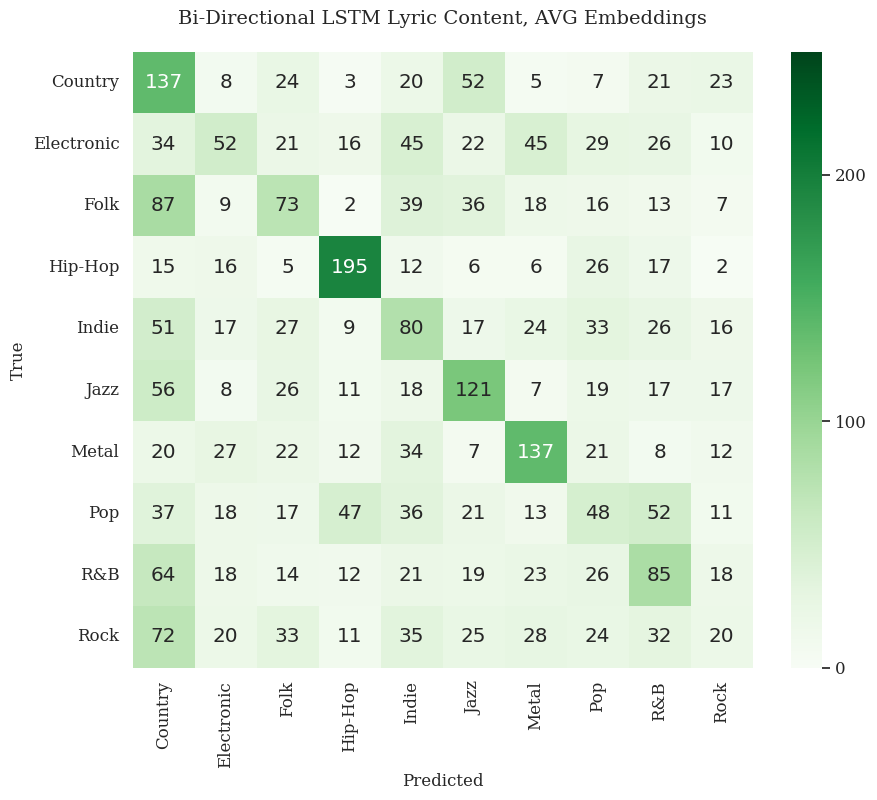

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
heatmap = sns.heatmap(cm, annot=True,fmt='d',cmap='Greens',xticklabels=genre_names,yticklabels=genre_names,vmin=0,
    vmax=250,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)
heatmap.set_yticklabels(
    heatmap.get_yticklabels(),
    fontdict={'fontsize': 12, 'fontweight': 'normal', 'fontfamily': 'Serif'},
)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.set_major_locator(MultipleLocator(100))

for label in cbar.ax.yaxis.get_ticklabels():
    label.set_fontname('Serif')
    label.set_fontsize(12)

plt.xlabel('Predicted', fontsize=12, fontfamily='Serif')
plt.ylabel('True', fontsize=12, fontfamily='Serif')
plt.title('Bi-Directional LSTM Lyric Content, AVG Embeddings', fontsize=14, fontfamily='Serif', pad = 20)

plt.savefig('/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/bilstm_content_avg.png', bbox_inches='tight')

#### b. Method 2 - Use TF-IDF weightings of sentence-level embeddings (word2vec) to create document representation

Create the embeddings

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix_train = tfidf_vectorizer.fit_transform(train_lr['Lyrics'])
tfidf_matrix_val = tfidf_vectorizer.transform(val_lr['Lyrics'])

Process the train/validation for use in the model

In [ ]:
train_lr['Embeddings'] = train_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))
val_lr['Embeddings'] = val_lr['Lyrics as Lists'].apply(lambda x: lyrics_to_embeddings(x, model_w2v))

In [ ]:
X_train = np.column_stack([tfidf_matrix_train.toarray(), np.vstack(train_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])
X_val = np.column_stack([tfidf_matrix_val.toarray(), np.vstack(val_lr['Embeddings'].apply(lambda x: np.mean(x, axis=0)))])

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [ ]:
train_lr['Genre'] = train_lr['Genre'].astype('category').cat.codes
val_lr['Genre'] = val_lr['Genre'].astype('category').cat.codes

# need to convert genre labels to one-hot encoding to use the keras library
num_classes = len(train_lr['Genre'].unique())
y_train = tf.keras.utils.to_categorical(train_lr['Genre'], num_classes=num_classes)
y_val = tf.keras.utils.to_categorical(val_lr['Genre'], num_classes=num_classes)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(y_train))
print(len(y_val))

12000
3000
12000
3000


Compile the Model

In [ ]:
X_train_array = np.array([np.array(embeddings) for embeddings in X_train])

In [ ]:
print(X_train_array.shape)

(12000, 44151)


In [ ]:
# sequence length is 44151
sequence_length = X_train_array.shape[1]

# reshaping for use in lstm, needs number of features (one, the word embeddings vector)
X_train_array = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1], 1)

In [ ]:
model_lstm = Sequential()
model_lstm.add(Bidirectional(LSTM(units=32, return_sequences=False), input_shape=(sequence_length, 1)))
model_lstm.add(Dense(units=10, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Train the Model

- trying with batch size of 64, for faster training

In [ ]:
# alternate
batch_size = 64
epochs = 10

# I want to save the best model weights from the epochs I trained
checkpoint_criteria = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch64.h5", monitor='val_loss',save_best_only=True)

model_lstm.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs, callbacks = checkpoint_criteria, validation_split=0.2)

Epoch 1/10
150/150 [==============================] - 275s 2s/step - loss: 2.2593 - accuracy: 0.1528 - val_loss: 2.2407 - val_accuracy: 0.1637
Epoch 2/10
150/150 [==============================] - 269s 2s/step - loss: 2.2239 - accuracy: 0.1758 - val_loss: 2.2176 - val_accuracy: 0.1933
Epoch 3/10
150/150 [==============================] - 269s 2s/step - loss: 2.1992 - accuracy: 0.1969 - val_loss: 2.2047 - val_accuracy: 0.1963
Epoch 4/10
150/150 [==============================] - 270s 2s/step - loss: 2.1786 - accuracy: 0.2125 - val_loss: 2.1887 - val_accuracy: 0.2117
Epoch 5/10
150/150 [==============================] - 270s 2s/step - loss: 2.1464 - accuracy: 0.2208 - val_loss: 2.1481 - val_accuracy: 0.2175
Epoch 6/10
150/150 [==============================] - 271s 2s/step - loss: 2.1043 - accuracy: 0.2369 - val_loss: 2.1201 - val_accuracy: 0.2313
Epoch 7/10
150/150 [==============================] - 271s 2s/step - loss: 2.0840 - accuracy: 0.2445 - val_loss: 2.1084 - val_accuracy: 0.2338

- batch size of 32, for greater amount of data per epoch so hopefully better generalization

In [ ]:
model_lstm_2 = Sequential()
model_lstm_2.add(Bidirectional(LSTM(units=32, return_sequences=False), input_shape=(sequence_length, 1)))
model_lstm_2.add(Dense(units=num_classes, activation='softmax'))

model_lstm_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 10
checkpoint_criteria = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32.h5", monitor='val_loss',save_best_only=True)

model_lstm_2.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs, callbacks = checkpoint_criteria, validation_split=0.2)

Epoch 1/10
300/300 [==============================] - 530s 2s/step - loss: 2.2586 - accuracy: 0.1490 - val_loss: 2.2389 - val_accuracy: 0.1646
Epoch 2/10
300/300 [==============================] - 523s 2s/step - loss: 2.2197 - accuracy: 0.1817 - val_loss: 2.2124 - val_accuracy: 0.1988
Epoch 3/10
300/300 [==============================] - 522s 2s/step - loss: 2.1729 - accuracy: 0.2134 - val_loss: 2.2050 - val_accuracy: 0.1846
Epoch 4/10
300/300 [==============================] - 523s 2s/step - loss: 2.1994 - accuracy: 0.1912 - val_loss: 2.1961 - val_accuracy: 0.2004
Epoch 5/10
 51/300 [====>.........................] - ETA: 6:31 - loss: 2.1835 - accuracy: 0.2114

KeyboardInterrupt: ignored

In [ ]:
model_lstm_2.save("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32.h5")

In [ ]:
# reloading model to continue training bc i had to close my comptuer at some point
reloaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32.h5")

In [ ]:
batch_size = 32
epochs = 10
checkpoint_criteria = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32.h5", monitor='val_loss',save_best_only=True)

reloaded_model.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs, callbacks = checkpoint_criteria, validation_split=0.2)

Epoch 1/10
300/300 [==============================] - 533s 2s/step - loss: 2.1710 - accuracy: 0.2154 - val_loss: 2.1860 - val_accuracy: 0.2054
Epoch 2/10
300/300 [==============================] - 525s 2s/step - loss: 2.1606 - accuracy: 0.2217 - val_loss: 2.1780 - val_accuracy: 0.2087
Epoch 3/10
300/300 [==============================] - 528s 2s/step - loss: 2.1500 - accuracy: 0.2237 - val_loss: 2.1694 - val_accuracy: 0.2179
Epoch 4/10
300/300 [==============================] - 526s 2s/step - loss: 2.1399 - accuracy: 0.2310 - val_loss: 2.1605 - val_accuracy: 0.2179
Epoch 5/10
300/300 [==============================] - 527s 2s/step - loss: 2.1278 - accuracy: 0.2379 - val_loss: 2.1429 - val_accuracy: 0.2279
Epoch 6/10
300/300 [==============================] - 528s 2s/step - loss: 2.1168 - accuracy: 0.2397 - val_loss: 2.1348 - val_accuracy: 0.2296
Epoch 7/10
300/300 [==============================] - 528s 2s/step - loss: 2.1146 - accuracy: 0.2364 - val_loss: 2.1245 - val_accuracy: 0.2404

In [ ]:
reloaded_model = load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32.h5")

batch_size = 32
epochs = 10
checkpoint_criteria = ModelCheckpoint("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32_more", monitor='val_loss',save_best_only=True)

reloaded_model.fit(X_train_array, y_train, batch_size=batch_size, epochs=epochs, callbacks = checkpoint_criteria, validation_split=0.2)

Epoch 1/10
300/300 [==============================] - 532s 2s/step - loss: 2.0547 - accuracy: 0.2583 - val_loss: 2.1411 - val_accuracy: 0.2354
Epoch 2/10
300/300 [==============================] - 527s 2s/step - loss: 2.0581 - accuracy: 0.2554 - val_loss: 2.0750 - val_accuracy: 0.2492
Epoch 3/10
300/300 [==============================] - 526s 2s/step - loss: 2.0423 - accuracy: 0.2616 - val_loss: 2.0578 - val_accuracy: 0.2604
Epoch 4/10
300/300 [==============================] - 525s 2s/step - loss: 2.0380 - accuracy: 0.2655 - val_loss: 2.0597 - val_accuracy: 0.2633
Epoch 5/10
300/300 [==============================] - 525s 2s/step - loss: 2.0314 - accuracy: 0.2656 - val_loss: 2.0594 - val_accuracy: 0.2571
Epoch 6/10
300/300 [==============================] - 527s 2s/step - loss: 2.0289 - accuracy: 0.2657 - val_loss: 2.0568 - val_accuracy: 0.2554
Epoch 7/10
300/300 [==============================] - 525s 2s/step - loss: 2.0279 - accuracy: 0.2685 - val_loss: 2.0447 - val_accuracy: 0.2679

Evaluate the model

In [ ]:
# process X_val in the same way as the training data was so that the model can make a prediction
X_val_processed = np.array([np.array(embeddings) for embeddings in X_val])
X_val_processed = X_val_processed.reshape(X_val_processed.shape[0], X_val_processed.shape[1], 1)

- model one with batch size 64

In [ ]:
best_model = load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch64.h5")

In [ ]:
y_pred = best_model.predict(X_val_processed)

y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
accuracy

94/94 [==============================] - 66s 693ms/step


0.24833333333333332

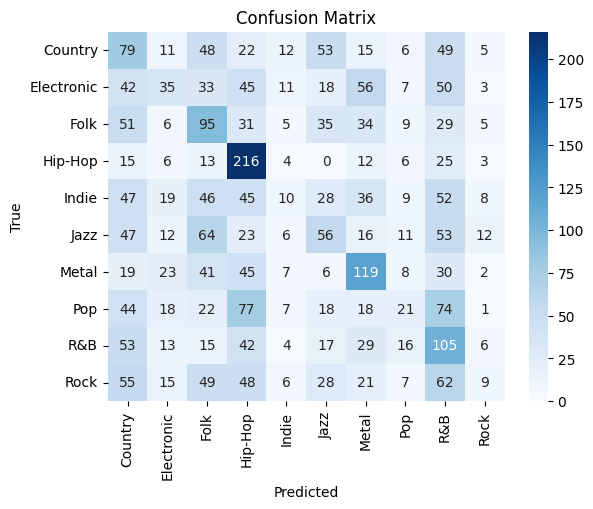

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

- model with batch size of 32

In [ ]:
# process X_val in the same way as the training data was so that the model can make a prediction
X_val_processed = np.array([np.array(embeddings) for embeddings in X_val])
X_val_processed = X_val_processed.reshape(X_val_processed.shape[0], X_val_processed.shape[1], 1)

In [ ]:
best_model_2 = load_model("/content/drive/MyDrive/Colab Notebooks/DATA340_NLP_FINAL/model_lstm_batch32_more.h5")

In [ ]:
y_pred = best_model_2.predict(X_val_processed)

y_true = np.argmax(y_val, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
accuracy = accuracy_score(y_true, y_pred_classes)
accuracy

94/94 [==============================] - 73s 721ms/step


0.277

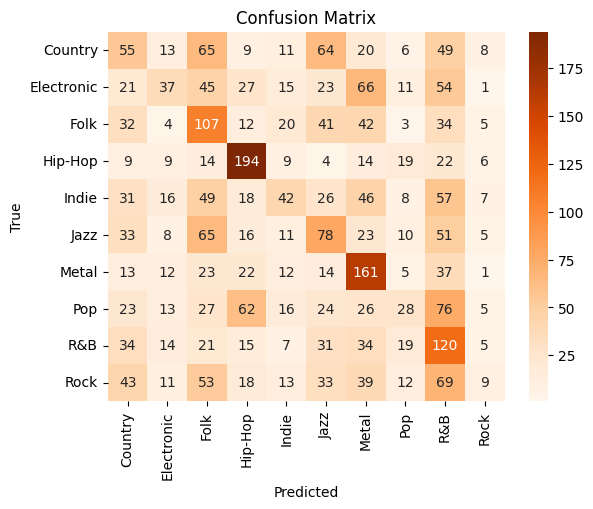

In [ ]:
genre_names = ['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Pop', 'R&B', 'Rock']


sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=genre_names, yticklabels=genre_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()